In [1]:
# Import packages
import time
from collections import deque, namedtuple
import gym
from gym import spaces
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [2]:
# Import utils custom module and dataset
from google.colab import files
uploaded = files.upload()
uploaded_data = files.upload()

import utils

Saving utils.py to utils.py


Saving masked_data.csv to masked_data.csv


In [ ]:
path_file = 'masked_data.csv'
raw_data = pd.read_csv(path_file)

def process_data(df):
    """
    Process and modify the dataset by:
    - Converting 'date_id' to datetime and sorting by 'product_id' and 'date_id'
    - Adding month, day_of_week, value (sales / units), and price_per_unit
    - Filtering rows where product_id == 1
    - Adding previous_price, previous_units_sold columns
    - Adding time_step based on date_id

    Args:
    - df: The original DataFrame

    Returns:
    - A processed and modified DataFrame
    """

    df = df.drop('Unnamed: 0', axis=1)
    df['date_id'] = pd.to_datetime(df['date_id'])
    df.sort_values(by=['product_id', 'date_id'], inplace=True)
    df['value'] = df['sales'] / df['units']
    df['price_per_unit'] = df['price'] / df['units']

    # Filter for product_id == 1
    df_filtered = df[df['product_id'] == 1].copy()
    df_filtered.drop('category_id', axis=1, inplace=True)
    df_filtered['time_step'] = df_filtered['date_id'].rank().astype(int)
    df_filtered['previous_price_per_unit'] = df_filtered['price_per_unit'].shift(1)
    df_filtered['previous_units_sold'] = df_filtered['units'].shift(1)

    df_filtered.dropna(inplace=True)

    return df_filtered

data = process_data(raw_data)


In [10]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):

    scaler = MinMaxScaler(feature_range=(0, 1))
    columns_to_normalize = ['sales', 'price', 'units', 'value', 'price_per_unit', 'previous_price_per_unit', 'previous_units_sold']
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    return df

data = normalize_data(data)


In [11]:
data.head()

,date_id,product_id,sales,price,units,value,price_per_unit,time_step,previous_price_per_unit,previous_units_sold
89343,2021-09-28,1,0.052989,0.052228,0.153471,0.110896,0.144254,2,0.115295,0.210913
72243,2021-09-29,1,0.132648,0.090662,0.291579,0.115720,0.070473,3,0.144254,0.153471
82244,2021-09-30,1,0.087658,0.058382,0.228228,0.094660,0.073518,4,0.070473,0.291579
80606,2021-10-01,1,0.095294,0.057378,0.226070,0.114753,0.073802,5,0.073518,0.228228
66305,2021-10-02,1,0.159982,0.133094,0.280943,0.184061,0.146614,6,0.073802,0.226070


In [7]:
# Set the random seed for TensorFlow
tf.random.set_seed(utils.SEED)

## 2 - Hyperparameters

In [8]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

## 3 Price Optimization

The goal of the Price Optimization environment is to identify the optimal price for a product in order to maximize sales revenue. The environment simulates the effect of different price points on sales and revenue. The price is adjusted through a discrete set of actions, each representing a different price level or change to the current price. The environment provides feedback in the form of sales revenue generated based on the chosen price.

The environment begins with a product having an initial price, units sold, and sales data. The agent's task is to adjust the price to maximize the revenue, which is calculated as price * units sold. The agent is allowed to make price adjustments through discrete actions. The environment is considered solved when the agent consistently identifies the price that results in the highest possible revenue for the product.

### 3.1 Action Space

The agent has five discrete actions available:

* Decreasing by 10%
* Decreasing by 5%
* No change
* Increasing by 5%
* Increasing by 10%.

```python
price_adjustments = [-0.1, -0.05, 0, 0.05, 0.1]
```
### 3.2 Observation Space

The agent's observation space consists of a state vector with 5 variables:

* Current Price: The current price of the product.
* Previous Price: The previous price of the product.
* Current Demand: The demand (units) at the current price.
* Previous Demand: The demand (units) at the previous price.
* Current Sales: Total value of units sold.





### 3.3 Rewards
After every step, a reward is granted. The total reward of an episode is the sum of the rewards for all steps within that episode.

#### Reward Components

1. **Revenue Maximization Reward**
   * Directly proportional to the sales revenue generated (price * units sold)
   * Encourages the agent to find price points that maximize total revenue

2. **Price Stability Penalty**
   * Small negative reward for large price changes between consecutive steps
   * Discourages frequent, drastic price fluctuations
   * Calculation: `-0.1 * |current_price - previous_price| / initial_price`

3. **Price Range Exploration Penalty**
   * Mild negative reward for prices at the extreme ends of the price range
   * Encourages exploring the entire price spectrum
   * Calculation:
     - If price is near minimum or maximum price: `-0.05 * (1 - abs(current_price - median_price) / price_range)`

4. **Consistency Bonus**
   * Small positive reward for maintaining a price point that generates stable revenue
   * Rewards finding a consistent, optimal pricing strategy
   * Calculation:
     - Track revenue variance over last N steps
     - If revenue variance is low: `+0.1 * (1 - normalized_revenue_variance)`

5. **Market Responsiveness Reward**
   * Positive reward for detecting and adapting to changes in market demand
   * Penalizes slow response to market shifts
   * Calculation:
     - Compare revenue trends over recent steps
     - If revenue trend shows intelligent adaptation: `+0.2`
     - If revenue trend shows poor adaptation: `-0.2`

#### Total Reward Equation
```
total_reward = (revenue_reward
                + price_stability_penalty
                + price_range_exploration_penalty
                + consistency_bonus
                + market_responsiveness_reward)
```

## 4 - Load the Environment

The goal the environment is to help an agent figure out the best price to sell a product in order to make the most money. This is done by experimenting with different prices and seeing how the sales change in response to the price adjustments. The agent needs to keep adjusting the price to maximize revenue (price * units sold).


In [14]:
class PriceOptimizationEnv(gym.Env):
    def __init__(self, data):  # Explicitly add data parameter
        super().__init__()

        # Prepare price levels for action space
        # Create discrete price adjustment actions
        self.price_adjustments = np.array([-0.1, -0.05, 0, 0.05, 0.1])
        self.action_space = spaces.Discrete(len(self.price_adjustments))

        # Define observation space
        # Select key features for state representation
        observation_features = [
            'price_per_unit',
            'units',
            'sales',
            'previous_price_per_unit',
            'previous_units_sold'
        ]

        # Create observation space bounds
        low_bounds = data[observation_features].min().values.astype(np.float32)
        high_bounds = data[observation_features].max().values.astype(np.float32)

        self.observation_space = spaces.Box(
            low=low_bounds,
            high=high_bounds,
            dtype=np.float32
        )

        # Store data and initialize
        self.data = data
        self.current_step = 0

    def reset(self):
        # Reset the environment to the initial state
        self.current_step = 0
        return self._get_observation()

    def step(self, action):
        # Get the price adjustment percentage
        price_adjustment = self.price_adjustments[action]

        # Calculate new price per unit
        current_price = self.data['price_per_unit'].iloc[self.current_step]
        new_price_per_unit = current_price * (1 + price_adjustment)

        # Simulate sales based on price change
        predicted_units = self._predict_units(new_price_per_unit)

        # Calculate reward (revenue)
        reward = new_price_per_unit * predicted_units

        # Move to next step
        self.current_step += 1

        # Check if episode is done
        done = self._is_episode_done()

        return self._get_observation(), reward, done, {
            'current_price': new_price_per_unit,
            'predicted_units': predicted_units
        }

    def _get_observation(self):
        # Extract state features for current step
        observation_features = [
            'price_per_unit',
            'units',
            'sales',
            'previous_price_per_unit',
            'previous_units_sold'
        ]
        return self.data.iloc[self.current_step][observation_features].values

    def _predict_units(self, price_per_unit):
        # Simple prediction method
        # Use linear interpolation based on historical data
        return np.interp(
            price_per_unit,
            self.data['price_per_unit'],
            self.data['units']
        )

    def _is_episode_done(self):
        # End episode when we reach the end of the dataset
        return self.current_step >= len(self.data) - 1


In [15]:
# Create the environment
env = PriceOptimizationEnv(data)

# Test the environment
state = env.reset()  # Initialize the environment and get the first state
print("Initial State:", state)

# Run a few steps to demonstrate the agent interacting with the environment
for step in range(5):
    action = env.action_space.sample()  # Random action from action space
    next_state, reward, done, info = env.step(action)

    # Print the results of each step
    print(f"\nStep {step + 1}:")
    print(f"Action: {action} (Price Adjustment: {env.price_adjustments[action] * 100}%)")
    print(f"Reward: {reward}")
    print(f"Current Price: {info['current_price']:.4f}")
    print(f"Predicted Units: {info['predicted_units']:.2f}")
    print(f"Done: {done}")

    if done:
        print("Episode finished.")
        break


Initial State: [0.1442544323062553 0.1534706879720495 0.05298887208737327
 0.11529488696634355 0.21091301443765093]

Step 1:
Action: 3 (Price Adjustment: 5.0%)
Reward: 0.04272463796988164
Current Price: 0.1515
Predicted Units: 0.28
Done: False

Step 2:
Action: 0 (Price Adjustment: -10.0%)
Reward: 0.00973393778710462
Current Price: 0.0634
Predicted Units: 0.15
Done: False

Step 3:
Action: 3 (Price Adjustment: 5.0%)
Reward: 0.011847016704896723
Current Price: 0.0772
Predicted Units: 0.15
Done: False

Step 4:
Action: 1 (Price Adjustment: -5.0%)
Reward: 0.01076018071553882
Current Price: 0.0701
Predicted Units: 0.15
Done: False

Step 5:
Action: 4 (Price Adjustment: 10.0%)
Reward: 0.016932905575704774
Current Price: 0.1613
Predicted Units: 0.10
Done: False


In [17]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)


State Shape: (5,)
Number of actions: 5


In [18]:
# Reset the environment to get the initial state
current_state = env.reset()

## 6 - Deep Q-Learning

In cases where both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

In [19]:
# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_actions, activation='linear')
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_actions, activation='linear')
    ])

optimizer = Adam(learning_rate=ALPHA)

In [20]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [22]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calculates the loss for the price optimization problem.

    Args:
      experiences: (tuple) Tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    states, actions, rewards, next_states, done_vals = experiences
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    y_targets = rewards + (1.0 - done_vals) * gamma * max_qsa
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    loss = MSE(y_targets, q_values)

    return loss


In [23]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks for the Price Optimization problem.

    Args:
      experiences: (tuple) Tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    """

    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    gradients = tape.gradient(loss, q_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
    utils.update_target_network(q_network, target_q_network)


In [25]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_revenue_history = []

num_p_av = 100
epsilon = 1.0

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_revenue = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)
        state_qn = tf.convert_to_tensor(state_qn, dtype=tf.float32)
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)
        next_state, reward, done, _ = env.step(action)
        memory_buffer.append(experience(state, action, reward, next_state, done))
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            experiences = utils.get_experiences(memory_buffer)
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_revenue += reward

        if done:
            break

    total_revenue_history.append(total_revenue)
    av_latest_revenue = np.mean(total_revenue_history[-num_p_av:])

    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total revenue average of the last {num_p_av} episodes: {av_latest_revenue:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total revenue average of the last {num_p_av} episodes: {av_latest_revenue:.2f}")

    if   >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('price_optimization_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")


Episode 100 | Total revenue average of the last 100 episodes: 134.38
Episode 200 | Total revenue average of the last 100 episodes: 136.69
Episode 300 | Total revenue average of the last 100 episodes: 137.79
Episode 400 | Total revenue average of the last 100 episodes: 138.66
Episode 500 | Total revenue average of the last 100 episodes: 139.78
Episode 600 | Total revenue average of the last 100 episodes: 140.56
Episode 700 | Total revenue average of the last 100 episodes: 141.05
Episode 800 | Total revenue average of the last 100 episodes: 140.89
Episode 900 | Total revenue average of the last 100 episodes: 140.95
Episode 1000 | Total revenue average of the last 100 episodes: 140.80
Episode 1100 | Total revenue average of the last 100 episodes: 140.95
Episode 1200 | Total revenue average of the last 100 episodes: 141.16
Episode 1300 | Total revenue average of the last 100 episodes: 141.04
Episode 1400 | Total revenue average of the last 100 episodes: 140.72
Episode 1500 | Total revenue 

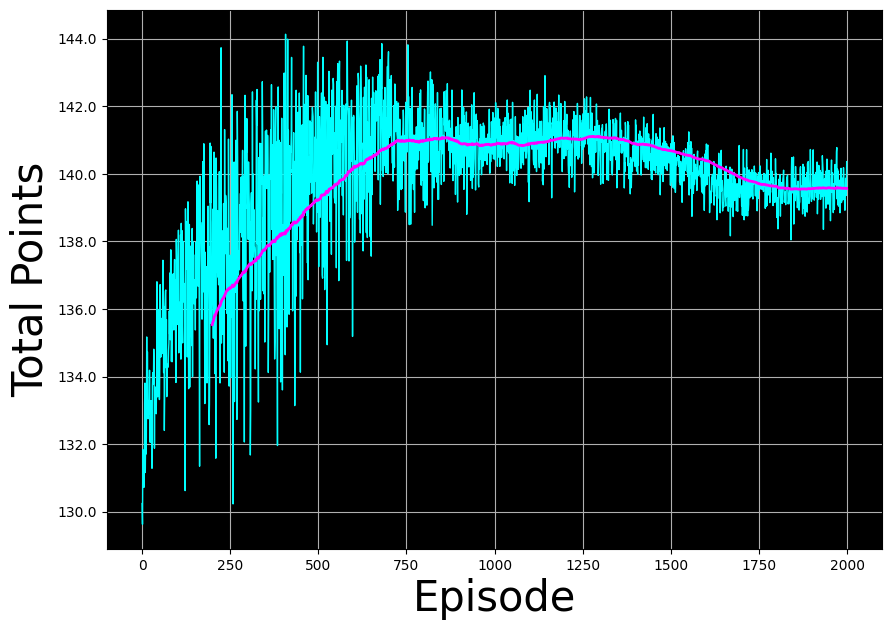

In [26]:
# Plot the total revenue history along with the moving average
utils.plot_history(total_revenue_history, title="Total Revenue History", ylabel="Total Revenue", xlabel="Episodes")
